In [106]:
import os
import sys

# Добавляем корневую директорию проекта в sys.path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../../")))

# Импортируем metrics из utils
from utils import metrics as mtc

In [107]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Готовим дата-сеты с регионом

In [108]:
reference = pd.read_csv("../../data/preprocessed/exp22/reference.csv")
train = pd.read_csv("../../data/preprocessed/exp22/train.csv")
valid = pd.read_csv("../../data/preprocessed/exp22/valid.csv")


In [109]:
reference.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 305 entries, 0 to 304
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      305 non-null    int64 
 1   region  305 non-null    object
 2   exp5    305 non-null    object
dtypes: int64(1), object(2)
memory usage: 7.3+ KB


In [110]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550 entries, 0 to 549
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   exp5       548 non-null    object
 1   school_id  550 non-null    int64 
 2   region     428 non-null    object
dtypes: int64(1), object(2)
memory usage: 13.0+ KB


In [111]:
valid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 184 entries, 0 to 183
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   exp5       184 non-null    object
 1   school_id  184 non-null    int64 
 2   region     140 non-null    object
dtypes: int64(1), object(2)
memory usage: 4.4+ KB


In [112]:
reference.head()

,id,region,exp5
0,69,мурманская область,кировска
1,70,московская область,клин спортивный
2,71,калининградская область,спортивная школа псковской области зимние виды...
3,8,свердловская область,айсберг
4,73,челябинская область,команда дмитриева


In [113]:
valid.head()

,exp5,school_id,region
0,спортивная школа олимпийского резерва,198,санкт петербург
1,мауо спортивная школа 11,184,липецкая область
2,лига фигурного катания,293,москва
3,клуб фигурного катания динамо,277,санкт петербург
4,мбау всеволжская спортивная школа олимпийского...,35,ленинградская область


### Преобразования в np.array

In [114]:
x_train = train["exp5"].to_numpy(dtype="str").flatten()
y_train = train["school_id"].to_numpy(dtype="int").flatten()
region_train = train["region"].to_numpy(dtype="str").flatten()

x_valid = valid["exp5"].to_numpy(dtype="str").flatten()
y_valid = valid["school_id"].to_numpy(dtype="int").flatten()
region_valid = valid["region"].to_numpy(dtype="str").flatten()

reference_id = reference["id"].to_numpy(dtype="int").flatten()
reference_name = reference["exp5"].to_numpy(dtype="str").flatten()
reference_region = reference["region"].to_numpy(dtype="str").flatten()


In [137]:
import joblib

joblib.dump(
    reference_id, "../../resources/cosine_region_manual_resources/reference_id.joblib"
)
joblib.dump(
    reference_region,
    "../../resources/cosine_region_manual_resources/reference_region.joblib",
)
joblib.dump(
    reference_name,
    "../../resources/cosine_region_manual_resources/reference_name.joblib",
)


['../../resources/cosine_region_manual_resources/reference_name.joblib']

# Построение модели

In [115]:
from sklearn.metrics.pairwise import euclidean_distances, manhattan_distances


def calculate_similarity(x, y, method="cosine"):
    if method == "cosine":
        return cosine_similarity(x, y)
    elif method == "euclidean":
        return -euclidean_distances(x, y)  # Инвертируем, чтобы максимизировать схожесть
    elif method == "manhattan":
        return -manhattan_distances(x, y)  # Инвертируем, чтобы максимизировать схожесть
    else:
        raise ValueError(f"Unknown similarity method: {method}")

In [116]:
def find_matches(
    x_vec,
    x_region,
    reference_id,
    reference_vec,
    reference_region,
    top_k=5,
    threshold=0.9,
    filter_by_region=True,
    empty_region="all",
    similarity_method="cosine",
):
    y_pred = []
    manual_review = []

    for i, x in enumerate(x_vec):
        # Фильтруем reference_vec и reference_id по текущему региону, если включена фильтрация по регионам
        if filter_by_region:
            # Фильтруем reference_vec и reference_id по текущему региону
            current_region = x_region[i]
            region_mask = reference_region == current_region
            filtered_reference_vec = reference_vec[region_mask]
            filtered_reference_id = reference_id[region_mask]

            # Способ обработки, если в текущем регионе нет школ для сравнения
            if empty_region == "all":
                # Если в текущем регионе нет школ для сравнения, используем все школы
                if filtered_reference_vec.shape[0] == 0:
                    filtered_reference_vec = reference_vec
                    filtered_reference_id = reference_id
            else:
                if filtered_reference_vec.shape[0] == 0:
                    # Если в текущем регионе нет школ для сравнения, то помечаем на ручную обработку
                    manual_review.append(x)
                    top_matches = [(None, 0.0)] * top_k
                    y_pred.append(top_matches)
                    continue
        else:
            filtered_reference_vec = reference_vec
            filtered_reference_id = reference_id

        # Вычисляем выбранное расстояние
        similarities = calculate_similarity(
            x, filtered_reference_vec, method=similarity_method
        ).flatten()
        top_indices = similarities.argsort()[-top_k:][::-1]
        max_similarity = max(similarities)

        # Учитываем пороговое значение для различных методов
        if similarity_method == "cosine":
            if max_similarity < threshold:
                manual_review.append(x)
                top_matches = [(None, 0.0)] * top_k
            else:
                top_matches = [
                    (filtered_reference_id[i], similarities[i]) for i in top_indices
                ]
                if len(top_matches) < top_k:
                    top_matches += [(None, 0.0)] * (top_k - len(top_matches))
        else:  # Для других методов расстояний (евклидово и манхэттенское)
            if max_similarity > -threshold:  # Обратите внимание на инверсию
                manual_review.append(x)
                top_matches = [(None, 0.0)] * top_k
            else:
                top_matches = [
                    (filtered_reference_id[i], -similarities[i]) for i in top_indices
                ]
                if len(top_matches) < top_k:
                    top_matches += [(None, 0.0)] * (top_k - len(top_matches))

        y_pred.append(top_matches)

    return y_pred, manual_review

# Использование модели

In [79]:
# Векторизация текстов
vectorizer = TfidfVectorizer().fit(np.append(x_train, reference_name))
x_vec_valid = vectorizer.transform(x_valid)
reference_vec = vectorizer.transform(reference_name)

In [124]:
import joblib

joblib.dump(
    vectorizer, "../../resources/cosine_region_manual_resources/vectorizer.joblib"
)


['../../resources/cosine_region_manual_resources/vectorizer.joblib']

In [125]:
joblib.dump(
    reference_vec, "../../resources/cosine_region_manual_resources/reference_vec.joblib"
)

['../../resources/cosine_region_manual_resources/reference_vec.joblib']

In [138]:
# Массив значений threshold
threshold_values = np.linspace(0.0, 1.0, 25)

# Запуск функции и сбор метрик
metrics_list = []
for threshold in threshold_values:
    y_pred, manual_review = find_matches(
        x_vec_valid,
        region_valid,
        reference_id,
        reference_vec,
        reference_region,
        top_k=5,
        threshold=threshold,
        filter_by_region=False,
        empty_region="all",
        # similarity_method="euclidean",
        similarity_method="cosine",
        # similarity_method="manhattan",
    )
    metrics = mtc.calculate_metrics(y_valid, y_pred, manual_review)
    metrics_list.append(metrics)

# Преобразование метрик в удобный формат для построения графика
auto_error_rate_values = [metrics["auto_error_rate"] for metrics in metrics_list]
manual_processing_rate_values = [
    metrics["manual_processing_rate"] for metrics in metrics_list
]
# general_spend_values = [metrics['general_spend'] for metrics in metrics_list]
general_error_values = [metrics["general_error"] for metrics in metrics_list]

In [139]:
plots_json = {
    "threshold_values": threshold_values.tolist(),
    "auto_error_rate_values": auto_error_rate_values,
    "manual_processing_rate_values": manual_processing_rate_values,
    "general_error_values": general_error_values,
}


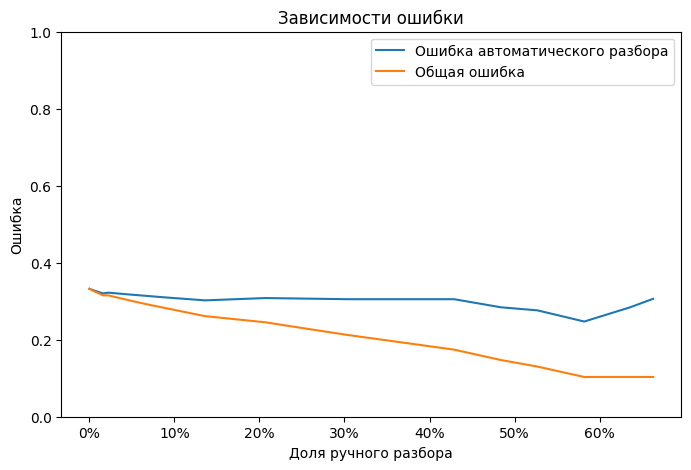

In [141]:
from matplotlib.ticker import PercentFormatter

# Построение графика
plt.figure(figsize=(8, 5))

# plt.subplot(1, 2, 1)
plt.plot(
    manual_processing_rate_values,
    auto_error_rate_values,
    label="Ошибка автоматического разбора",
)
plt.plot(manual_processing_rate_values, general_error_values, label="Общая ошибка")
plt.xlabel("Доля ручного разбора")
plt.ylabel("Ошибка")
plt.title("Зависимости ошибки")
plt.legend()

# Установка формата осей в процентах
plt.gca().xaxis.set_major_formatter(PercentFormatter(1))
# plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

# Установка максимального значения оси y
plt.ylim(0, 1.0)

plt.show()


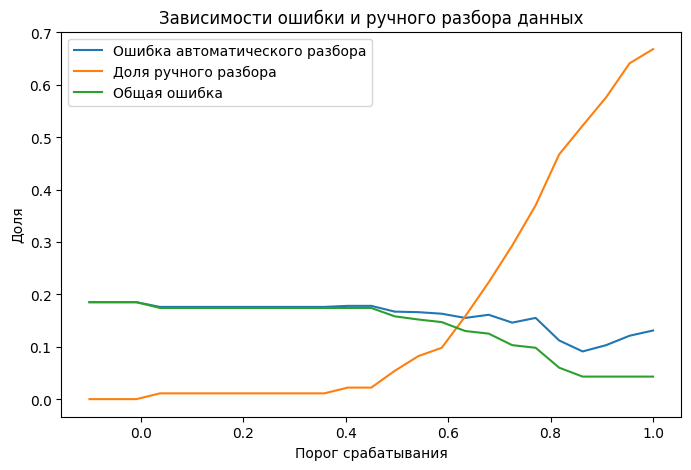

In [104]:
# Определение общих границ для оси y
y_min = min(min(auto_error_rate_values), min(manual_processing_rate_values))
y_max = max(max(auto_error_rate_values), max(manual_processing_rate_values))

# Построение графика
plt.figure(figsize=(8, 5))

# plt.subplot(1, 2, 1)
plt.plot(
    threshold_values, auto_error_rate_values, label="Ошибка автоматического разбора"
)
plt.plot(
    threshold_values,
    manual_processing_rate_values,
    label="Доля ручного разбора",
)
plt.plot(threshold_values, general_error_values, label="Общая ошибка")
plt.xlabel("Порог срабатывания")
plt.ylabel("Доля")
plt.title("Зависимости ошибки и ручного разбора данных")
plt.legend()

plt.show()


In [105]:
y_pred, manual_review = find_matches(
    x_vec_valid,
    region_valid,
    reference_id,
    reference_vec,
    reference_region,
    top_k=5,
    threshold=-1,
    filter_by_region=True,
    empty_region="all",  # is ignored if filter_by_region=False
    # similarity_method="euclidean",
    similarity_method="cosine",
    # similarity_method="manhattan",
)

metrics = mtc.calculate_metrics(y_valid, y_pred, manual_review)
metrics

{'Accuracy@1': 0.815,
 'Accuracy@3': 0.973,
 'Accuracy@5': 0.973,
 'auto_error_rate': 0.185,
 'manual_processing_rate': 0.0,
 'general_error': 0.185}